In [1]:
# INIT

import random
import collections
import numpy as np
import plotly
import plotly.plotly as py
import plotly.tools as tls
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime
import scipy as sp
import copy as cp
import pickle
import os
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import diffusion_functions as dm
from sklearn.preprocessing import normalize
from pygsp import graphs, filters, plotting
from jupyterthemes import jtplot
from scipy.linalg import eig

plotting.BACKEND = 'matplotlib'
# plt.rcParams['figure.figsize'] = (8.0, 4.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['font.family'] = 'Times New Roman'
# plt.rcParams['font.size'] = 12
# plt.rcParams['image.cmap'] = 'gray'

np.set_printoptions(precision=3,linewidth=250,suppress=True)

>> Functions loaded from diffusion_functions.py


In [2]:
plt.rcParams['text.usetex'] = True
jtplot.style(grid=False, figsize=(6, 4))
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['font.family'] = 'Times New Roman'

fontsize = 18
plt.rcParams['font.size'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['axes.titlesize'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
# plt.rcParams['mathtext.fontset'] = 'custom'
# plt.rcParams['mathtext.rm'] = 'DejaVu Sans'
# plt.rcParams['mathtext.it'] = 'asd:italic'
# plt.rcParams['mathtext.bf'] = 'DejaVu Sans:bold'

In [3]:
simfun = dm.diffusion_similarity_v2

## Defining Network

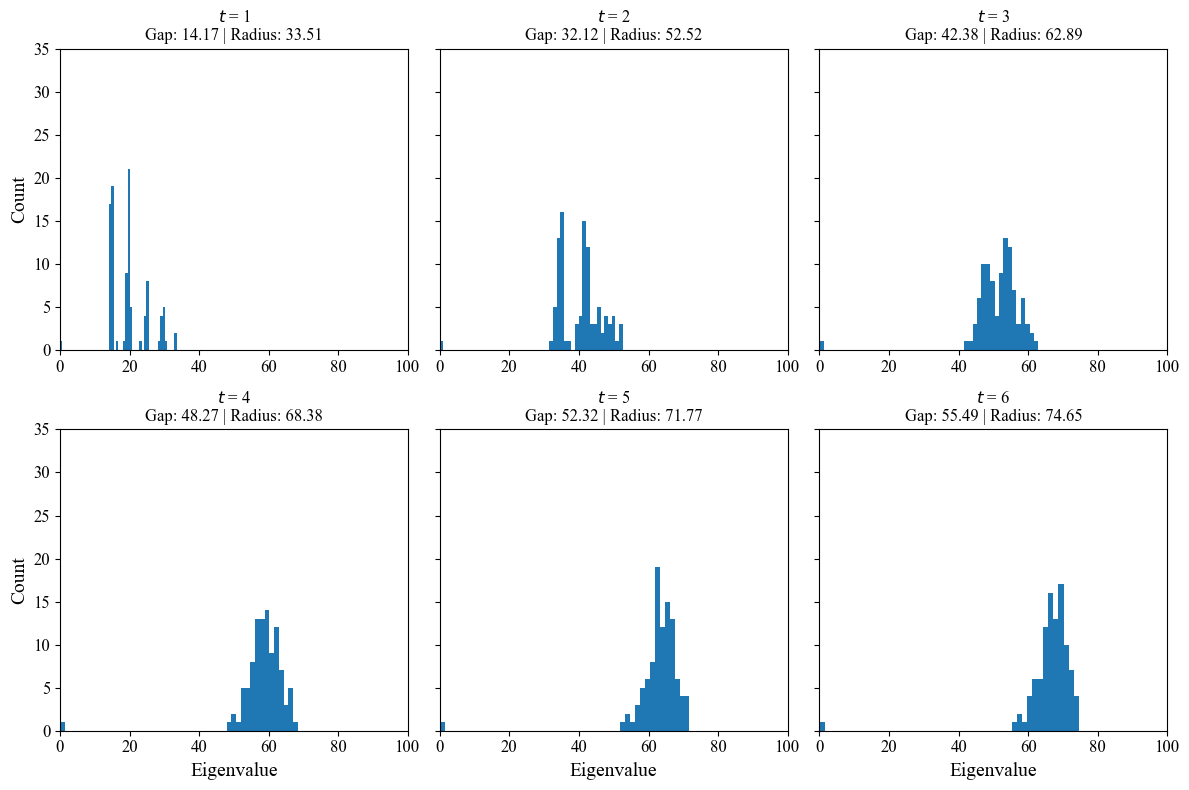

In [4]:
# PARAMETERS #######################################################
jtplot.reset()
np.random.seed(0)
network_sizes = [100]
# network_sizes = [20, 50, 100, 200, 300, 400]

step_instants = [1,2,3,4,5,6]
transforms = ['A','L','L_norm','B1','C1','LC1','BS','CS','LCS']
# transforms_laplacian = ['L','LC1','LCS','LD1','LDS']
transforms_laplacian = ['L', 'LD1']


k_neighbors = 4
K = 10; #time_instants
# END PARAMETERS ###################################################

spectra = {}
coeffs_normal = {}
coeffs_anom = {}
result_f1 = {}
result_f2 = {}


for N in network_sizes:
    disconnected = True
    while disconnected:
        features = 10*np.random.rand(N,2)
        s = np.ones((N,1))


        graphplotparams = {'vertex_size': 75,
                         'vertex_color': 'indigo',
                         'edge_color': 'lightgrey',
                         'edge_width': 1,
                         'edge_style': '-'}
        bargraphplotparams = {'vertex_size': 75,
                 'vertex_color': 'indigo',
                 'edge_color': 'black',
                 'edge_width': 0.5,
                 'edge_style': '-.'}
        G = graphs.NNGraph(features,k=k_neighbors,center=False, rescale=False, plotting=graphplotparams)
        disconnected = not G.is_connected()



coords = G.coords
A = G.A.toarray()*1.
D = np.diag(G.d)
L = D-A
L_norm = sp.linalg.fractional_matrix_power(D,-0.5).dot(L.dot(sp.linalg.fractional_matrix_power(D,-0.5)))

# ## Consensus algorithm: Perron matrix
epsilon = 1./(D.max()*1.25)
W = np.eye(N) # b = 0 # W[b,b] = 0.1
P = np.eye(N)-epsilon*W.dot(L)

spectra_N = {}

result_f1_step = {}
result_f2_step = {}



plt.figure(figsize=(12,8))
for step in step_instants:

    DS = simfun(P,t=step,H=True)
    LDS = np.diag(DS.sum(axis=0))-DS

    spectra_N['LDS'+str(step)] = np.linalg.eigvalsh(LDS)
    
    if step==600:
        plt.subplot(2,3,6)
    else:
        plt.subplot(2,3,step)
    plt.xlim((0,100))
    plt.ylim((0,35))
    plt.hist(spectra_N['LDS'+str(step)], bins=N/2)
    
    plt.title(r'$t$ = '+str(step)+'\nGap: '+str(round(spectra_N['LDS'+str(step)][1],2))+' | Radius: '+str(round(spectra_N['LDS'+str(step)][-1],2))   ,fontname='Times New Roman'       )
#     plt.title('Eigenvalue histogram N'+str(N)+'K'+str(k_neighbors))

#     if ~step%2==0:
#         plt.ylabel('Count',fontsize=14,fontname='Times New Roman')
#     else:
#         plt.tick_params(
#         axis='y',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         left=True,      # ticks along the bottom edge are off
#         top=False,         # ticks along the top edge are off
#         labelleft=False) # labels along the bottom edge are off
        
    if (step==1 or step==4):
        plt.ylabel('Count',fontsize=14,fontname='Times New Roman')
    else:
        plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off
        
    plt.yticks(fontname='Times New Roman',fontsize=12)
    plt.xticks(fontname='Times New Roman',fontsize=12)
    
    if step>=4:
        plt.xlabel('Eigenvalue',fontsize=14,fontname='Times New Roman')
#     else:
#         plt.tick_params(
#         axis='x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom=False,      # ticks along the bottom edge are off
#         left=True,
#         right=False,
#         top=False,         # ticks along the top edge are off
#         labelbottom=False) # labels along the bottom edge are off

plt.tight_layout()
plt.savefig('../paperfigs/spectrum_analysis_xticks_2x3.eps',format='eps')
plt.show()

In [5]:
np.linalg.eigvalsh(L)

array([0.   , 0.058, 0.116, 0.186, 0.248, 0.343, 0.398, 0.529, 0.662, 0.814, 1.015, 1.153, 1.284, 1.382, 1.598, 1.795, 2.057, 2.482, 2.578, 2.748, 2.94 , 3.009, 3.047, 3.523, 3.564, 3.647, 3.733, 3.853, 3.954, 4.156, 4.277, 4.34 , 4.477, 4.517,
       4.57 , 4.617, 4.682, 4.764, 4.859, 4.93 , 4.961, 5.   , 5.   , 5.   , 5.   , 5.   , 5.   , 5.   , 5.091, 5.117, 5.235, 5.355, 5.405, 5.465, 5.585, 5.635, 5.646, 5.734, 5.862, 5.936, 5.957, 6.   , 6.108, 6.228, 6.26 , 6.369, 6.413, 6.491,
       6.557, 6.598, 6.678, 6.725, 6.746, 6.784, 6.823, 6.882, 6.958, 7.   , 7.   , 7.   , 7.067, 7.124, 7.466, 7.515, 7.532, 7.692, 7.726, 7.878, 7.993, 8.142, 8.159, 8.192, 8.233, 8.398, 8.521, 8.795, 8.858, 8.949, 9.515, 9.738])

In [6]:
D

array([[4, 0, 0, ..., 0, 0, 0],
       [0, 6, 0, ..., 0, 0, 0],
       [0, 0, 4, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 5, 0, 0],
       [0, 0, 0, ..., 0, 5, 0],
       [0, 0, 0, ..., 0, 0, 4]])

In [7]:
LDS

array([[71.96 , -0.925, -0.815, ..., -0.705, -0.733, -0.596],
       [-0.925, 74.105, -0.834, ..., -0.76 , -0.76 , -0.615],
       [-0.815, -0.834, 68.625, ..., -0.67 , -0.709, -0.573],
       ...,
       [-0.705, -0.76 , -0.67 , ..., 70.997, -0.72 , -0.586],
       [-0.733, -0.76 , -0.709, ..., -0.72 , 73.914, -0.855],
       [-0.596, -0.615, -0.573, ..., -0.586, -0.855, 60.427]])

In [8]:
v1 = dm.diffusion_similarity(P,t=1000,H=True)
LDSv1 = np.diag(v1.sum(axis=0))-v1
np.linalg.eigvalsh(LDSv1)

array([  0., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.])

In [46]:
v2 = simfun(P,t=0,H=True)
LDSv2 = np.diag(v2.sum(axis=0))-v2
np.linalg.eigvalsh(LDSv2)

array([-0.   ,  0.68 ,  0.685,  0.692,  0.699,  0.708,  0.714,  0.727,  0.74 ,  0.755,  0.775,  0.789,  0.802,  0.812,  0.834,  0.853,  0.879,  0.922,  0.932,  0.949,  0.968,  0.975,  0.978,  1.026,  1.03 ,  1.039,  1.047,  1.059,  1.069,  1.089,
        1.101,  1.108,  1.121,  1.125,  1.131,  1.135,  1.142,  1.15 ,  1.16 ,  1.167,  1.17 ,  1.174,  1.174,  1.174,  1.174,  1.174,  1.174,  1.174,  1.183,  1.185,  1.197,  1.209,  1.214,  1.22 ,  1.232,  1.237,  1.238,  1.247,  1.26 ,  1.267,
        1.27 ,  1.274,  1.285,  1.297,  1.3  ,  1.311,  1.315,  1.323,  1.33 ,  1.334,  1.342,  1.346,  1.348,  1.352,  1.356,  1.362,  1.37 ,  1.374,  1.374,  1.374,  1.381,  1.386,  1.42 ,  1.425,  1.427,  1.443,  1.446,  1.462,  1.473,  1.488,
        1.49 ,  1.493,  1.497,  1.514,  1.526,  1.553,  1.56 ,  1.569,  1.625,  1.648])

In [10]:
v1.sum(axis=1)

array([99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99.,
       99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99.,
       99., 99., 99., 99.])

In [11]:
v2.sum(axis=1)

array([99.4, 99.6, 99.4, 99.6, 99.4, 99.4, 99.4, 99.4, 99.4, 99.5, 99.4, 99.4, 99.6, 99.5, 99.5, 99.4, 99.5, 99.4, 99.6, 99.7, 99.4, 99.5, 99.5, 99.6, 99.4, 99.4, 99.4, 99.7, 99.8, 99.4, 99.4, 99.6, 99.7, 99.5, 99.5, 99.4, 99.5, 99.5, 99.6, 99.7,
       99.4, 99.5, 99.4, 99.5, 99.7, 99.4, 99.5, 99.5, 99.4, 99.5, 99.7, 99.4, 99.5, 99.5, 99.4, 99.6, 99.5, 99.5, 99.7, 99.6, 99.5, 99.6, 99.4, 99.4, 99.6, 99.4, 99.5, 99.7, 99.5, 99.5, 99.4, 99.6, 99.5, 99.5, 99.4, 99.7, 99.5, 99.5, 99.5, 99.5,
       99.5, 99.4, 99.4, 99.4, 99.7, 99.4, 99.5, 99.5, 99.4, 99.5, 99.6, 99.5, 99.5, 99.8, 99.7, 99.4, 99.4, 99.5, 99.5, 99.4])

In [12]:
P.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [13]:
G = cp.deepcopy(P)

In [14]:
np.fill_diagonal(G,0)
G

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
G.sum(axis=1)

array([0.4, 0.6, 0.4, 0.6, 0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.4, 0.4, 0.6, 0.5, 0.5, 0.4, 0.5, 0.4, 0.6, 0.7, 0.4, 0.5, 0.5, 0.6, 0.4, 0.4, 0.4, 0.7, 0.8, 0.4, 0.4, 0.6, 0.7, 0.5, 0.5, 0.4, 0.5, 0.5, 0.6, 0.7, 0.4, 0.5, 0.4, 0.5, 0.7, 0.4, 0.5, 0.5,
       0.4, 0.5, 0.7, 0.4, 0.5, 0.5, 0.4, 0.6, 0.5, 0.5, 0.7, 0.6, 0.5, 0.6, 0.4, 0.4, 0.6, 0.4, 0.5, 0.7, 0.5, 0.5, 0.4, 0.6, 0.5, 0.5, 0.4, 0.7, 0.5, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.7, 0.4, 0.5, 0.5, 0.4, 0.5, 0.6, 0.5, 0.5, 0.8, 0.7, 0.4,
       0.4, 0.5, 0.5, 0.4])

In [16]:
DG = np.diag(G.sum(axis=1))

In [17]:
DG

array([[0.4, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0.6, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0.4, ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.5, 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0.5, 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0.4]])

In [18]:
np.linalg.eigvalsh(DG)

array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.8, 0.8])

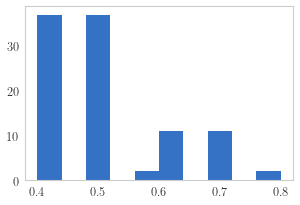

In [19]:
plt.hist(np.linalg.eigvalsh(DG))
plt.show()

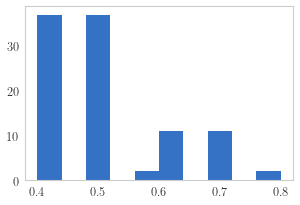

In [20]:
plt.hist(G.sum(axis=1))
plt.show()

In [21]:
LG = DG - G

In [22]:
LG

array([[0.4, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0.6, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0.4, ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.5, 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0.5, 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0.4]])

In [23]:
np.linalg.eigvalsh(LG)

array([0.   , 0.006, 0.012, 0.019, 0.025, 0.034, 0.04 , 0.053, 0.066, 0.081, 0.101, 0.115, 0.128, 0.138, 0.16 , 0.179, 0.206, 0.248, 0.258, 0.275, 0.294, 0.301, 0.305, 0.352, 0.356, 0.365, 0.373, 0.385, 0.395, 0.416, 0.428, 0.434, 0.448, 0.452,
       0.457, 0.462, 0.468, 0.476, 0.486, 0.493, 0.496, 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.509, 0.512, 0.524, 0.535, 0.541, 0.547, 0.559, 0.563, 0.565, 0.573, 0.586, 0.594, 0.596, 0.6  , 0.611, 0.623, 0.626, 0.637, 0.641, 0.649,
       0.656, 0.66 , 0.668, 0.672, 0.675, 0.678, 0.682, 0.688, 0.696, 0.7  , 0.7  , 0.7  , 0.707, 0.712, 0.747, 0.752, 0.753, 0.769, 0.773, 0.788, 0.799, 0.814, 0.816, 0.819, 0.823, 0.84 , 0.852, 0.879, 0.886, 0.895, 0.951, 0.974])

In [24]:
np.linalg.eigvalsh(G)

array([-0.318, -0.309, -0.297, -0.286, -0.274, -0.266, -0.259, -0.258, -0.246, -0.238, -0.236, -0.227, -0.222, -0.214, -0.21 , -0.196, -0.194, -0.191, -0.186, -0.182, -0.172, -0.167, -0.166, -0.164, -0.163, -0.156, -0.151, -0.138, -0.131, -0.129,
       -0.125, -0.123, -0.116, -0.111, -0.102, -0.1  , -0.1  , -0.1  , -0.1  , -0.1  , -0.1  , -0.1  , -0.1  , -0.1  , -0.1  , -0.1  , -0.1  , -0.092, -0.084, -0.081, -0.073, -0.069, -0.064, -0.06 , -0.052, -0.049, -0.046, -0.041, -0.036, -0.031,
       -0.024, -0.016, -0.011, -0.006,  0.002,  0.004,  0.022,  0.024,  0.033,  0.05 ,  0.053,  0.075,  0.086,  0.101,  0.118,  0.126,  0.129,  0.146,  0.154,  0.167,  0.178,  0.207,  0.239,  0.241,  0.26 ,  0.287,  0.314,  0.333,  0.35 ,  0.354,
        0.421,  0.442,  0.445,  0.456,  0.494,  0.503,  0.514,  0.53 ,  0.536,  0.563])

In [25]:
LP = np.diag(P.sum(axis=1))-P

In [26]:
np.diag(P)

array([0.6, 0.4, 0.6, 0.4, 0.6, 0.6, 0.6, 0.6, 0.6, 0.5, 0.6, 0.6, 0.4, 0.5, 0.5, 0.6, 0.5, 0.6, 0.4, 0.3, 0.6, 0.5, 0.5, 0.4, 0.6, 0.6, 0.6, 0.3, 0.2, 0.6, 0.6, 0.4, 0.3, 0.5, 0.5, 0.6, 0.5, 0.5, 0.4, 0.3, 0.6, 0.5, 0.6, 0.5, 0.3, 0.6, 0.5, 0.5,
       0.6, 0.5, 0.3, 0.6, 0.5, 0.5, 0.6, 0.4, 0.5, 0.5, 0.3, 0.4, 0.5, 0.4, 0.6, 0.6, 0.4, 0.6, 0.5, 0.3, 0.5, 0.5, 0.6, 0.4, 0.5, 0.5, 0.6, 0.3, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.3, 0.6, 0.5, 0.5, 0.6, 0.5, 0.4, 0.5, 0.5, 0.2, 0.3, 0.6,
       0.6, 0.5, 0.5, 0.6])

In [27]:
LP == np.diag(np.diag(P)) + LG

array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [28]:
np.all(np.eye(N) == np.diag(np.diag(P)) + DG)

False

In [29]:
np.all(DG)

False

In [30]:
np.all(G==P-np.diag(np.diag(P)))

True

In [31]:
np.all(np.eye(N)==np.diag(P.sum(axis=1)))

False

In [32]:
P.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [33]:
1==1.

True

In [34]:
F = np.diag(P.sum(axis=1))

In [35]:
np.diag(np.eye(N)-F)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [36]:
LP

array([[0.4, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0.6, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0.4, ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.5, 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0.5, 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0.4]])

In [37]:
LG

array([[0.4, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0.6, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0.4, ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.5, 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0.5, 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0.4]])

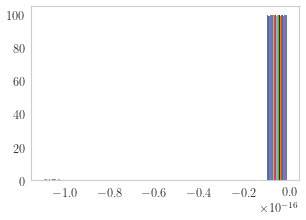

In [38]:
plt.hist(LP-LG)
plt.show()

In [39]:
np.linalg.eigvalsh(LG)

array([0.   , 0.006, 0.012, 0.019, 0.025, 0.034, 0.04 , 0.053, 0.066, 0.081, 0.101, 0.115, 0.128, 0.138, 0.16 , 0.179, 0.206, 0.248, 0.258, 0.275, 0.294, 0.301, 0.305, 0.352, 0.356, 0.365, 0.373, 0.385, 0.395, 0.416, 0.428, 0.434, 0.448, 0.452,
       0.457, 0.462, 0.468, 0.476, 0.486, 0.493, 0.496, 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.509, 0.512, 0.524, 0.535, 0.541, 0.547, 0.559, 0.563, 0.565, 0.573, 0.586, 0.594, 0.596, 0.6  , 0.611, 0.623, 0.626, 0.637, 0.641, 0.649,
       0.656, 0.66 , 0.668, 0.672, 0.675, 0.678, 0.682, 0.688, 0.696, 0.7  , 0.7  , 0.7  , 0.707, 0.712, 0.747, 0.752, 0.753, 0.769, 0.773, 0.788, 0.799, 0.814, 0.816, 0.819, 0.823, 0.84 , 0.852, 0.879, 0.886, 0.895, 0.951, 0.974])

In [40]:
np.linalg.eigvalsh(LB)

array([-0.   ,  0.006,  0.012,  0.019,  0.025,  0.034,  0.04 ,  0.053,  0.066,  0.081,  0.101,  0.115,  0.128,  0.138,  0.16 ,  0.179,  0.206,  0.248,  0.258,  0.275,  0.294,  0.301,  0.305,  0.352,  0.356,  0.365,  0.373,  0.385,  0.395,  0.416,
        0.428,  0.434,  0.448,  0.452,  0.457,  0.462,  0.468,  0.476,  0.486,  0.493,  0.496,  0.5  ,  0.5  ,  0.5  ,  0.5  ,  0.5  ,  0.5  ,  0.5  ,  0.509,  0.512,  0.524,  0.535,  0.541,  0.547,  0.559,  0.563,  0.565,  0.573,  0.586,  0.594,
        0.596,  0.6  ,  0.611,  0.623,  0.626,  0.637,  0.641,  0.649,  0.656,  0.66 ,  0.668,  0.672,  0.675,  0.678,  0.682,  0.688,  0.696,  0.7  ,  0.7  ,  0.7  ,  0.707,  0.712,  0.747,  0.752,  0.753,  0.769,  0.773,  0.788,  0.799,  0.814,
        0.816,  0.819,  0.823,  0.84 ,  0.852,  0.879,  0.886,  0.895,  0.951,  0.974])

In [41]:
np.linalg.eigvalsh(LA)

array([  0.   , 100.006, 100.012, 100.019, 100.025, 100.034, 100.04 , 100.053, 100.066, 100.081, 100.101, 100.115, 100.128, 100.138, 100.16 , 100.179, 100.206, 100.248, 100.258, 100.275, 100.294, 100.301, 100.305, 100.352, 100.356, 100.365, 100.373,
       100.385, 100.395, 100.416, 100.428, 100.434, 100.448, 100.452, 100.457, 100.462, 100.468, 100.476, 100.486, 100.493, 100.496, 100.5  , 100.5  , 100.5  , 100.5  , 100.5  , 100.5  , 100.5  , 100.509, 100.512, 100.524, 100.535, 100.54 , 100.546,
       100.558, 100.563, 100.565, 100.573, 100.586, 100.594, 100.596, 100.6  , 100.611, 100.623, 100.626, 100.637, 100.641, 100.649, 100.656, 100.66 , 100.668, 100.672, 100.675, 100.678, 100.682, 100.688, 100.696, 100.7  , 100.7  , 100.7  , 100.707,
       100.712, 100.747, 100.752, 100.753, 100.769, 100.773, 100.788, 100.799, 100.814, 100.816, 100.819, 100.823, 100.84 , 100.852, 100.879, 100.886, 100.895, 100.951, 100.974])

In [42]:
np.linalg.eigvalsh(P)

array([0.026, 0.049, 0.105, 0.114, 0.121, 0.148, 0.16 , 0.177, 0.181, 0.184, 0.186, 0.201, 0.212, 0.227, 0.231, 0.247, 0.248, 0.253, 0.288, 0.293, 0.3  , 0.3  , 0.3  , 0.304, 0.312, 0.318, 0.322, 0.325, 0.328, 0.332, 0.34 , 0.344, 0.351, 0.359,
       0.363, 0.374, 0.377, 0.389, 0.4  , 0.404, 0.406, 0.414, 0.427, 0.435, 0.437, 0.441, 0.453, 0.459, 0.465, 0.476, 0.488, 0.491, 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.504, 0.507, 0.514, 0.524, 0.532, 0.538, 0.543, 0.548, 0.552,
       0.566, 0.572, 0.584, 0.605, 0.615, 0.627, 0.635, 0.644, 0.648, 0.695, 0.699, 0.706, 0.725, 0.742, 0.752, 0.794, 0.821, 0.84 , 0.862, 0.872, 0.885, 0.899, 0.919, 0.934, 0.947, 0.96 , 0.966, 0.975, 0.981, 0.988, 0.994, 1.   ])

In [43]:
v2

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [44]:
v2[0:20,0:20]

array([[0. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1.1, 1. , 1. , 1. , 1. , 1. , 1. , 1.1, 1. ],
       [1. , 0. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1.1, 1. , 1. , 1. , 1.1, 1. ],
       [1. , 1. , 0. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1.1, 1. , 1. , 1. ],
       [1. , 1. , 1. , 0. , 1. , 1. , 1.1, 1. , 1. , 1. , 1. , 1.1, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 0. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 0. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1.1, 1. , 1. , 0. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 0. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1

In [45]:
P[0:20,0:20]

array([[0.6, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. ],
       [0. , 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0.1, 0. ],
       [0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.4, 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.1, 0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0